In [58]:
%pip install einops

Note: you may need to restart the kernel to use updated packages.


In [59]:
import os
import sys
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from einops import rearrange

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [61]:
module_path = '/home/srikanth/Downloads/conformer_helpers'
sys.path.append(os.path.dirname(module_path))

In [62]:
module_path = '/home/srikanth/Downloads/going_modular'
sys.path.append(os.path.dirname(module_path))

In [63]:
from going_modular.helper_functions import set_seeds
from going_modular import engine_new
from going_modular.helper_functions import plot_loss_curves

In [64]:
# from conformer_helpers import engine

In [65]:
root_path = r"/home/srikanth/Interns/RGB_images"
dataset_path = os.listdir(root_path)

In [66]:
class_labels = []

for item in dataset_path:
    #print(item)
    all_classes = os.listdir(root_path + '/' +item)
    for top_object in all_classes:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object)))

df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

In [67]:
f_dataloader = DataLoader(
      df,
      batch_size=16,
      shuffle=True)

In [68]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [69]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64), antialias=True),
        transforms.Normalize( mean= [0.51158103, 0.47950193, 0.46153474],
                             std=[0.22355489, 0.22948845, 0.24873442])
        ])
        self.label_mapping = label2id
    # class ImageDataset(Dataset):
    # def __init__(self, df, label2id, input_size=224, transform=None):
    #     self.df = df
    #     self.label_mapping = label2id
    #     resize_value = self.calculate_resize_value(input_size)
    #     self.transform = transform if transform else transforms.Compose([
    #         transforms.Resize((resize_value, resize_value), antialias=True),
    #         transforms.CenterCrop(input_size),
    #         transforms.ToTensor(),
    #         transforms.Normalize(mean=[0.51158103, 0.47950193, 0.46153474],
    #                              std=[0.22355489, 0.22948845, 0.24873442])
    #     ])

    # def calculate_resize_value(self, input_size):
    #     return int((256 / 224) * input_size)

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [70]:
def create_dataloaders(train_df,test_df,val_df,batch_size: int):
    # Use ImageFolder to create dataset(s)
    train_data = ImageDataset(train_df)
    test_data = ImageDataset(test_df)
    val_data = ImageDataset(val_df)

    # Get class names
    class_names = list(train_df['labels'].unique())

   # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True)
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False)
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False)

    return train_dataloader, test_dataloader, val_dataloader, class_names

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, trunc_normal_

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class ConvBlock(nn.Module):

    def __init__(self, inplanes, outplanes, stride=1, res_conv=False, act_layer=nn.ReLU, groups=1,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6), drop_block=None, drop_path=None):
        super(ConvBlock, self).__init__()

        expansion = 4
        med_planes = outplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=stride, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(outplanes)
        self.act3 = act_layer(inplace=True)

        if res_conv:
            self.residual_conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False)
            self.residual_bn = norm_layer(outplanes)

        self.res_conv = res_conv
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x, x_t=None, return_x_2=True):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x) if x_t is None else self.conv2(x + x_t)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x2 = self.act2(x)

        x = self.conv3(x2)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.res_conv:
            residual = self.residual_conv(residual)
            residual = self.residual_bn(residual)

        x += residual
        x = self.act3(x)

        if return_x_2:
            return x, x2
        else:
            return x


class FCUDown(nn.Module):
    """ CNN feature maps -> Transformer patch embeddings
    """

    def __init__(self, inplanes, outplanes, dw_stride, act_layer=nn.GELU,
                 norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super(FCUDown, self).__init__()
        self.dw_stride = dw_stride

        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.sample_pooling = nn.AvgPool2d(kernel_size=dw_stride, stride=dw_stride)

        self.ln = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, x_t):
        x = self.conv_project(x)  # [N, C, H, W]

        x = self.sample_pooling(x).flatten(2).transpose(1, 2)
        x = self.ln(x)
        x = self.act(x)

        x = torch.cat([x_t[:, 0][:, None, :], x], dim=1)

        return x


class FCUUp(nn.Module):
    """ Transformer patch embeddings -> CNN feature maps
    """

    def __init__(self, inplanes, outplanes, up_stride, act_layer=nn.ReLU,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6),):
        super(FCUUp, self).__init__()

        self.up_stride = up_stride
        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.bn = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, H, W):
        B, _, C = x.shape
        # [N, 197, 384] -> [N, 196, 384] -> [N, 384, 196] -> [N, 384, 14, 14]
        x_r = x[:, 1:].transpose(1, 2).reshape(B, C, H, W)
        x_r = self.act(self.bn(self.conv_project(x_r)))

        return F.interpolate(x_r, size=(H * self.up_stride, W * self.up_stride))


class Med_ConvBlock(nn.Module):
    """ special case for Convblock with down sampling,
    """
    def __init__(self, inplanes, act_layer=nn.ReLU, groups=1, norm_layer=partial(nn.BatchNorm2d, eps=1e-6),
                 drop_block=None, drop_path=None):

        super(Med_ConvBlock, self).__init__()

        expansion = 4
        med_planes = inplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=1, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, inplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(inplanes)
        self.act3 = act_layer(inplace=True)

        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        x += residual
        x = self.act3(x)

        return x


class ConvTransBlock(nn.Module):
    """
    Basic module for ConvTransformer, keep feature maps for CNN block and patch embeddings for transformer encoder block
    """

    def __init__(self, inplanes, outplanes, res_conv, stride, dw_stride, embed_dim, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 last_fusion=False, num_med_block=0, groups=1):

        super(ConvTransBlock, self).__init__()
        expansion = 4
        self.cnn_block = ConvBlock(inplanes=inplanes, outplanes=outplanes, res_conv=res_conv, stride=stride, groups=groups)

        if last_fusion:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, stride=2, res_conv=True, groups=groups)
        else:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, groups=groups)

        if num_med_block > 0:
            self.med_block = []
            for i in range(num_med_block):
                self.med_block.append(Med_ConvBlock(inplanes=outplanes, groups=groups))
            self.med_block = nn.ModuleList(self.med_block)

        self.squeeze_block = FCUDown(inplanes=outplanes // expansion, outplanes=embed_dim, dw_stride=dw_stride)

        self.expand_block = FCUUp(inplanes=embed_dim, outplanes=outplanes // expansion, up_stride=dw_stride)

        self.trans_block = Block(
            dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=drop_path_rate)

        self.dw_stride = dw_stride
        self.embed_dim = embed_dim
        self.num_med_block = num_med_block
        self.last_fusion = last_fusion

    def forward(self, x, x_t):
        x, x2 = self.cnn_block(x)

        _, _, H, W = x2.shape

        x_st = self.squeeze_block(x2, x_t)

        x_t = self.trans_block(x_st + x_t)

        if self.num_med_block > 0:
            for m in self.med_block:
                x = m(x)

        x_t_r = self.expand_block(x_t, H // self.dw_stride, W // self.dw_stride)
        x = self.fusion_block(x, x_t_r, return_x_2=False)

        return x, x_t

In [72]:
class Conformer(nn.Module):

    def __init__(self, patch_size=16, in_chans=3, num_classes=1000, base_channel=64, channel_ratio=4, num_med_block=0,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.):

        # Transformer
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        assert depth % 3 == 0

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.trans_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        # Classifier head
        self.trans_norm = nn.LayerNorm(embed_dim)
        self.trans_cls_head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.conv_cls_head = nn.Linear(int(256 * channel_ratio), num_classes)

        # Stem stage: get the feature maps by conv block (copied form resnet.py)
        self.conv1 = nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 / 2 [112, 112]
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 1 / 4 [56, 56]

        # 1 stage
        stage_1_channel = int(base_channel * channel_ratio)
        trans_dw_stride = patch_size // 4
        self.conv_1 = ConvBlock(inplanes=64, outplanes=stage_1_channel, res_conv=True, stride=1)
        self.trans_patch_conv = nn.Conv2d(64, embed_dim, kernel_size=trans_dw_stride, stride=trans_dw_stride, padding=0)
        self.trans_1 = Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                             qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=self.trans_dpr[0],
                             )

        # 2~4 stage
        init_stage = 2
        fin_stage = depth // 3 + 1
        for i in range(init_stage, fin_stage):
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        stage_1_channel, stage_1_channel, False, 1, dw_stride=trans_dw_stride, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )


        stage_2_channel = int(base_channel * channel_ratio * 2)
        # 5~8 stage
        init_stage = fin_stage # 5
        fin_stage = fin_stage + depth // 3 # 9
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_1_channel if i == init_stage else stage_2_channel
            res_conv = True if i == init_stage else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_2_channel, res_conv, s, dw_stride=trans_dw_stride // 2, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )

        stage_3_channel = int(base_channel * channel_ratio * 2 * 2)
        # 9~12 stage
        init_stage = fin_stage  # 9
        fin_stage = fin_stage + depth // 3  # 13
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_2_channel if i == init_stage else stage_3_channel
            res_conv = True if i == init_stage else False
            last_fusion = True if i == depth else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_3_channel, res_conv, s, dw_stride=trans_dw_stride // 4, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block, last_fusion=last_fusion
                    )
            )
        self.fin_stage = fin_stage

        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}


    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # pdb.set_trace()
        # stem stage [N, 3, 224, 224] -> [N, 64, 56, 56]
        x_base = self.maxpool(self.act1(self.bn1(self.conv1(x))))

        # 1 stage
        x = self.conv_1(x_base, return_x_2=False)

        x_t = self.trans_patch_conv(x_base).flatten(2).transpose(1, 2)
        x_t = torch.cat([cls_tokens, x_t], dim=1)
        x_t = self.trans_1(x_t)
        
        # 2 ~ final 
        for i in range(2, self.fin_stage):
            x, x_t = eval('self.conv_trans_' + str(i))(x, x_t)

        # conv classification
        x_p = self.pooling(x).flatten(1)
        conv_cls = self.conv_cls_head(x_p)

        # trans classification
        x_t = self.trans_norm(x_t)
        tran_cls = self.trans_cls_head(x_t[:, 0])

        return [conv_cls, tran_cls]

In [73]:
LR=0.0001
EPOCHS=1
BATCH_SIZE = 16

In [74]:
from tqdm import tqdm
# import torch

def trainVal(model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device):
    best_acc = 0.0
    min_loss = min_val_loss

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Using tqdm for progress tracking
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Update the learning rate
        # scheduler.step()  # Uncomment if using a learning rate scheduler

        # Save the model if it has the best validation accuracy so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'min_loss': epoch_loss
            }
        torch.save(state, '/home/srikanth/Interns/Rajasree/CSIO-Conformer/weight/conformer-boc-rgbd.pth')

    return train_losses, train_accs, val_losses, val_accs, min_loss


Epoch 0/0
----------


Train Loss: 0.2926 Acc: 0.9171
Val Loss: 1.8891 Acc: 0.6578


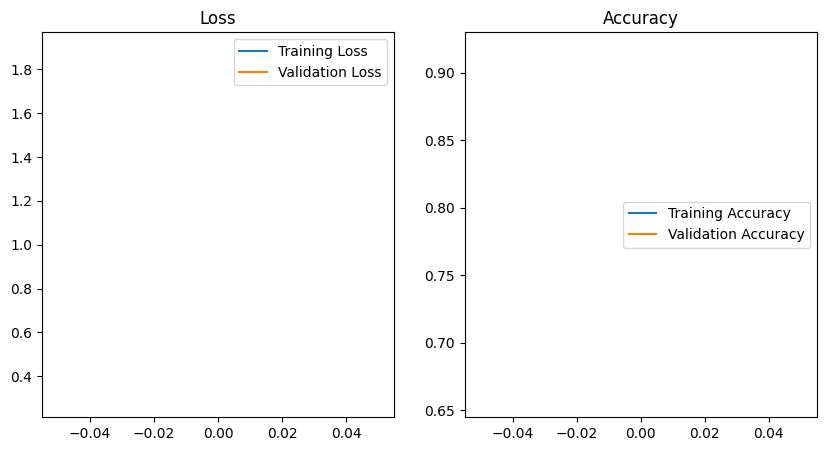

Confusion matrix: 
[[4915  306  698 1379]
 [  40 6910 1105  354]
 [1029 1028 4863  411]
 [ 167  163  108 5415]]
Precision: 0.7683676621063257
Recall: 0.765047938804472
F1 score: 0.7623914224231084
Epoch 0/0
----------


KeyboardInterrupt: 

In [75]:
features = [item[1] for item in class_labels]
labels = [item[0] for item in class_labels]
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
kfold.split(features, labels)

average_validation_accuracy = []
for train_indices, test_indices in kfold.split(features, labels):
    train_data = [(labels[i], features[i]) for i in train_indices]
    test_datas = [(labels[i], features[i]) for i in test_indices]
    #print(train_indices)
    num_fold = 2
    test_features = [item[1] for item in test_datas]
    test_labels = [item[0] for item in test_datas]
    kfold_test = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=42)
    for val_indice, test_indice in kfold_test.split(test_features, test_labels):
        val_data = [(test_labels[i], test_features[i]) for i in val_indice]
        test_data = [(test_labels[i], test_features[i]) for i in test_indice]

    # For getting the value address of train image
    new_train_value=[]
    for room in train_data:
        photo = os.listdir(room[1])
        for image in photo:
            new_train_value.append((room[0],str(room[1] +'/' +image)))

    #Creating the Dataframe for Train
    train_df= pd.DataFrame(data=new_train_value, columns=['labels', 'filepaths'])

    # For getting the value address of test image
    new_test_value=[]
    for room in test_data:
        photo = os.listdir(room[1])
        for image in photo:
            new_test_value.append((room[0],str(room[1] +'/' +image)))

    #Creating the Dataframe for Testing
    test_df= pd.DataFrame(data=new_test_value, columns=['labels', 'filepaths'])

    # For getting the value address of Validation image
    new_val_value=[]
    for room in val_data:
        photo = os.listdir(room[1])
        for image in photo:
            new_val_value.append((room[0],str(room[1] +'/' +image)))

    #Creating the Dataframe for Validation
    val_df= pd.DataFrame(data=new_val_value, columns=['labels', 'filepaths'])


#############################################################################################################################################
    # Create data loaders
    train_gen, test_gen, valid_gen, class_names = create_dataloaders(
        train_df=train_df,
        test_df=test_df,
        val_df=val_df,
        batch_size=BATCH_SIZE
    )

    train_gen, test_gen, valid_gen, class_names
    classes=labels
    class_count=len(classes)


#############################################################################################################################################

    # Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
    model = Conformer(patch_size=16, channel_ratio=6, embed_dim=576, depth=12,
                      num_heads=9, mlp_ratio=4, qkv_bias=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=LR)

    # Setup the loss function for multi-class classification
    loss_fn = torch.nn.CrossEntropyLoss()
    min_val_loss = float('inf')

    # Set the seeds
    #set_seeds()
    # Train the model and save the training results to a dictionary
    
    train_losses, train_accs, val_losses, val_accs, min_loss = trainVal(model, loss_fn, optimizer, EPOCHS, min_val_loss, train_gen, valid_gen, device)

    
    # Convert the tensors to NumPy arrays

    train_losses = torch.tensor(train_losses)
    val_losses = torch.tensor(val_losses)
    train_accs = torch.tensor(train_accs)
    val_accs = torch.tensor(val_accs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()


    #############################################################################################################################################
    # EVALUATION
    # model.eval()
    # y_true=[]
    # y_pred=[]
    # for _,(image, label) in enumerate(test_gen):
    #     y_true.extend(label.cpu().numpy())
    #     prediction =torch.argmax(torch.softmax(model(image.to(device)),dim=1),dim=1)
    #     prediction=prediction.cpu().numpy()
    #     y_pred.extend(prediction)
    model.eval()
    y_true = []
    y_pred = []

    for _, (image, label) in enumerate(test_gen):
        y_true.extend(label.cpu().numpy())
        outputs = model(image.to(device))

        # Handle the case where the output is a list of tensors
        if isinstance(outputs, list):
            batch_predictions = []
            for output in outputs:
                batch_predictions.append(torch.argmax(torch.softmax(output, dim=1), dim=1))
            # For simplicity, use the first output for prediction evaluation
            prediction = batch_predictions[0]
        else:
            prediction = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

        prediction = prediction.cpu().numpy()
        y_pred.extend(prediction)


    #confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion matrix: \n{cm}")

    #Metrics

    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")


In [ ]:
def test(model):
    model.eval()

    Sum = 0
    for inputs, labels in test_gen:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs).to(device).float()

        _,prediction = torch.max(output,1)

        pred_label = labels[prediction]
        pred_label = pred_label.detach().cpu().numpy()
        main_label = labels.detach().cpu().numpy()
        bool_list  = list(map(lambda x, y: x == y, pred_label, main_label))
        Sum += sum(np.array(bool_list)*1)

    print('Prediction: ', (Sum/len(test_gen.dataset)*100,'%'))

In [ ]:
test(model)

In [ ]:
test_losses = []
test_accuracies = []

all_preds = []
all_labels = []
model.eval()
total_test_loss = 0.0
correct_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # If the model outputs a list of tensors
        if isinstance(outputs, list):
            batch_loss = 0.0
            for output in outputs:
                batch_loss += criterion(output, labels).item()
            test_loss = batch_loss / len(outputs)
            total_test_loss += test_loss * images.size(0)

            # For simplicity, assuming the first output for prediction evaluation
            output = outputs[0]
        else:
            test_loss = criterion(outputs, labels).item()
            total_test_loss += test_loss * images.size(0)
            output = outputs

        pred = output.argmax(dim=1, keepdim=True)
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        
        # Gather predictions and true labels for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = total_test_loss / len(test_loader.dataset)
test_losses.append(average_test_loss)
test_accuracies.append(100. * correct_test / len(test_loader.dataset))
print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)